In [1]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import neurokit2 as nk
from pyts.image import GramianAngularField
from pyts.approximation import PiecewiseAggregateApproximation
import os
from pathlib import Path
import re
import random

In [2]:
# 90 * 8 * 2
data_path = Path('data/ptb/')
segment_path = Path('ecg_segment/')
sampling_rate = 1000 #500hz

In [3]:
def get_rpeaks(sig, sampling_rate):
    _, rpeaks = nk.ecg_peaks(sig, sampling_rate=sampling_rate)
    return rpeaks['ECG_R_Peaks']

In [4]:
heart_rates = []
ma = 0
for person_dir in data_path.iterdir():
    if person_dir.is_dir():
        person_name = person_dir.name
        for file in person_dir.iterdir(): 
            if file.suffix == ".dat":
                rec_path = person_dir.joinpath(file.stem)
                rc = wfdb.rdrecord(rec_path, channels=[1])
                dt = rc.p_signal.flatten()
                cl_sig = nk.ecg_clean(dt, sampling_rate=sampling_rate, method='hamilton2002')
                rpeaks = get_rpeaks(cl_sig, sampling_rate=sampling_rate)
                heart_rate = np.mean(nk.signal_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(cl_sig)))

D:\Tools\anaconda\envs\torch212\lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


In [5]:
def get_segment(clean_sig, heart_rate, rpeaks, sampling_rate):
    # heart_rate = np.mean(nk.signal_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(clean_sig)))
    # R峰前比例
    ratio_pre = 0.35
    window_size = 60 / heart_rate  # Beats  second
    epochs_start = ratio_pre * window_size
    epochs_end = (1 - ratio_pre) * window_size

    heartbeats = nk.epochs_create(clean_sig, 
                                  events=rpeaks, 
                                  epochs_start=-epochs_start, 
                                  epochs_end=epochs_end, 
                                  sampling_rate=sampling_rate)
    return heartbeats

    # df = nk.epochs_to_df(heartbeats)

In [6]:
def ecg_correlation(ecg1, ecg2):
    if len(ecg1) != len(ecg2):
        raise ValueError("信号长度必须相同")
    
    mean1 = np.mean(ecg1)
    mean2 = np.mean(ecg2)
    
    covariance = np.sum((ecg1 - mean1) * (ecg2 - mean2))
    std1 = np.sqrt(np.sum((ecg1 - mean1) ** 2))
    std2 = np.sqrt(np.sum((ecg2 - mean2) ** 2))
    
    if std1 * std2 == 0:
        return 0.0
    else:
        return covariance / (std1 * std2)

In [7]:
def write_segment(rc_pt, save_path, heart_rate):
    rc = wfdb.rdrecord(rc_pt, channels=[1])
    dt = rc.p_signal.flatten()
    cl_sig = nk.ecg_clean(dt, sampling_rate=sampling_rate, method='hamilton2002')
    rpeaks = get_rpeaks(cl_sig, sampling_rate=sampling_rate)
    heart_beats = get_segment(cl_sig, heart_rate, rpeaks=rpeaks, sampling_rate=sampling_rate)
    df = nk.epochs_to_df(heart_beats)
    df_pivoted = df.pivot(index="Time", columns="Label", values='Signal')
    median_heartbeat = df_pivoted.median(axis=1)
    
    del_cols = []
    for col in df_pivoted.columns:
        if ecg_correlation(df_pivoted[col], median_heartbeat) < 0.7:
            del_cols.append(col)
    df_pivoted = df_pivoted.drop(del_cols, axis=1)
    
    csv_save_path = save_path.joinpath(f'sample_{rc_pt.name}.csv')
    os.makedirs(os.path.dirname(csv_save_path), exist_ok=True)
    df_pivoted.to_csv(csv_save_path)

In [9]:
for idx, person_dir in enumerate(data_path.iterdir()):
    if person_dir.is_dir():
        person_name = person_dir.name
        rec_lst = []
        for rec_file in person_dir.iterdir():
            if re.search('rec', rec_file.stem) and rec_file.stem not in rec_lst:
                rec_lst.append(rec_file.stem)
        for rec in rec_lst:
            rec_path = person_dir.joinpath(rec)
            save_path = segment_path.joinpath(person_name)
            write_segment(rec_path, save_path, heart_rates[idx])

In [35]:
rc = wfdb.rdrecord('F:\summer\ecgprocess\data\ptb\patient001\s0010_re', channels=[1])
dt = rc.p_signal.flatten()
cl_sig = nk.ecg_clean(dt, sampling_rate=sampling_rate, method='hamilton2002')
rpeaks = get_rpeaks(cl_sig, sampling_rate=sampling_rate)
heart_rate = np.mean(nk.signal_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(cl_sig)))
heart_beats = get_segment(cl_sig, heart_rate, rpeaks, sampling_rate)
df = nk.epochs_to_df(heart_beats)
df_pivoted = df.pivot(index="Time", columns="Label", values='Signal')

In [36]:
df_pivoted

Label            1         10        11        12        13        14  \
Time                                                                    
-0.256141  0.032202  0.014188  0.003095  0.010763  0.007471 -0.000606   
-0.255139  0.033139  0.013884  0.003522  0.010420  0.006953 -0.000438   
-0.254138  0.033806  0.013601  0.003973  0.009576  0.006941  0.000153   
-0.253137  0.034273  0.012933  0.004787  0.008750  0.007116  0.000996   
-0.252136  0.034855  0.012516  0.005623  0.008192  0.006941  0.003056   
...             ...       ...       ...       ...       ...       ...   
 0.471685  0.013247  0.003095  0.014368  0.006941  0.005982  0.013559   
 0.472686  0.014436  0.003522  0.014399  0.006384  0.006525  0.013532   
 0.473687  0.015618  0.003973  0.014174  0.005738  0.006457  0.013869   
 0.474689  0.016666  0.004787  0.013534  0.005316  0.006029  0.014281   
 0.475690  0.017690  0.005623  0.012785  0.005048  0.006316  0.014724   

Label            15        16        17        18  ...        48        49  \
Time                                               ...                       
-0.256141  0.013926  0.009251 -0.000519  0.015583  ...  0.011534  0.006846   
-0.255139  0.014629  0.009357  0.000035  0.016598  ...  0.011409  0.006316   
-0.254138  0.014110  0.009423  0.000684  0.017077  ...  0.011454  0.005915   
-0.253137  0.013559  0.009538  0.001114  0.017154  ...  0.011464  0.005922   
-0.252136  0.013532  0.009637  0.001407  0.017266  ...  0.011198  0.006390   
...             ...       ...       ...       ...  ...       ...       ...   
 0.471685  0.009251  0.002993  0.015097  0.011334  ...  0.010117 -0.004790   
 0.472686  0.009357  0.003900  0.014224  0.010674  ...  0.009855 -0.005247   
 0.473687  0.009423  0.004192  0.013496  0.009761  ...  0.009717 -0.005496   
 0.474689  0.009538  0.003922  0.012945  0.009077  ...  0.009880 -0.005595   
 0.475690  0.009637  0.003621  0.012150  0.008358  ...  0.010355 -0.005466   

Label            5         50        51        52        6         7   \
Time                                                                    
-0.256141  0.013624 -0.004254  0.017832 -0.001446  0.009846  0.015213   
-0.255139  0.013777 -0.003603  0.018574 -0.001301  0.010071  0.015609   
-0.254138  0.013989 -0.002917  0.018489 -0.000937  0.010014  0.016117   
-0.253137  0.014318 -0.002300  0.017189 -0.000475  0.009726  0.016803   
-0.252136  0.014205 -0.001689  0.016053  0.000163  0.009319  0.017544   
...             ...       ...       ...       ...       ...       ...   
 0.471685  0.009303  0.018180  0.000790  0.000000  0.014012  0.011193   
 0.472686  0.008670  0.017930  0.000061  0.000000  0.014614  0.011575   
 0.473687  0.008246  0.017616 -0.000511  0.000000  0.015213  0.011967   
 0.474689  0.007962  0.017488 -0.000843  0.000000  0.015609  0.012293   
 0.475690  0.007689  0.017832 -0.000935  0.000000  0.016117  0.012518   

Label            8         9   
Time                           
-0.256141  0.012166  0.008558  
-0.255139  0.012166  0.009137  
-0.254138  0.012217  0.009508  
-0.253137  0.012242  0.010133  
-0.252136  0.012120  0.010971  
...             ...       ...  
 0.471685  0.003514  0.011997  
 0.472686  0.003591  0.010414  
 0.473687  0.003633  0.008318  
 0.474689  0.003632  0.006566  
 0.475690  0.003612  0.005186  

[732 rows x 52 columns]

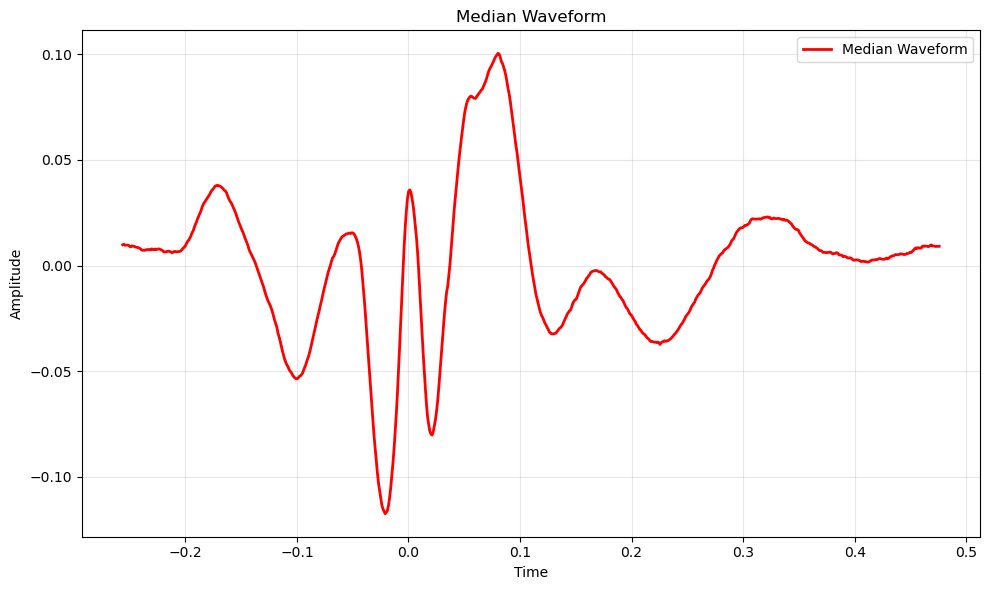

In [37]:
median_heartbeat = df_pivoted.median(axis=1)
plt.figure(figsize=(10, 6))
median_heartbeat.plot(color='red', linewidth=2, label='Median Waveform')
plt.title('Median Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def paa(sig):
    L = len(sig)
    time_points = np.linspace(1, L, L).tolist()
    result = [time_points, sig]
    transformer = PiecewiseAggregateApproximation(window_size=None, output_size=224)
    resultPAA = transformer.transform(result)
    N = np.array(resultPAA[1, :])
    return N

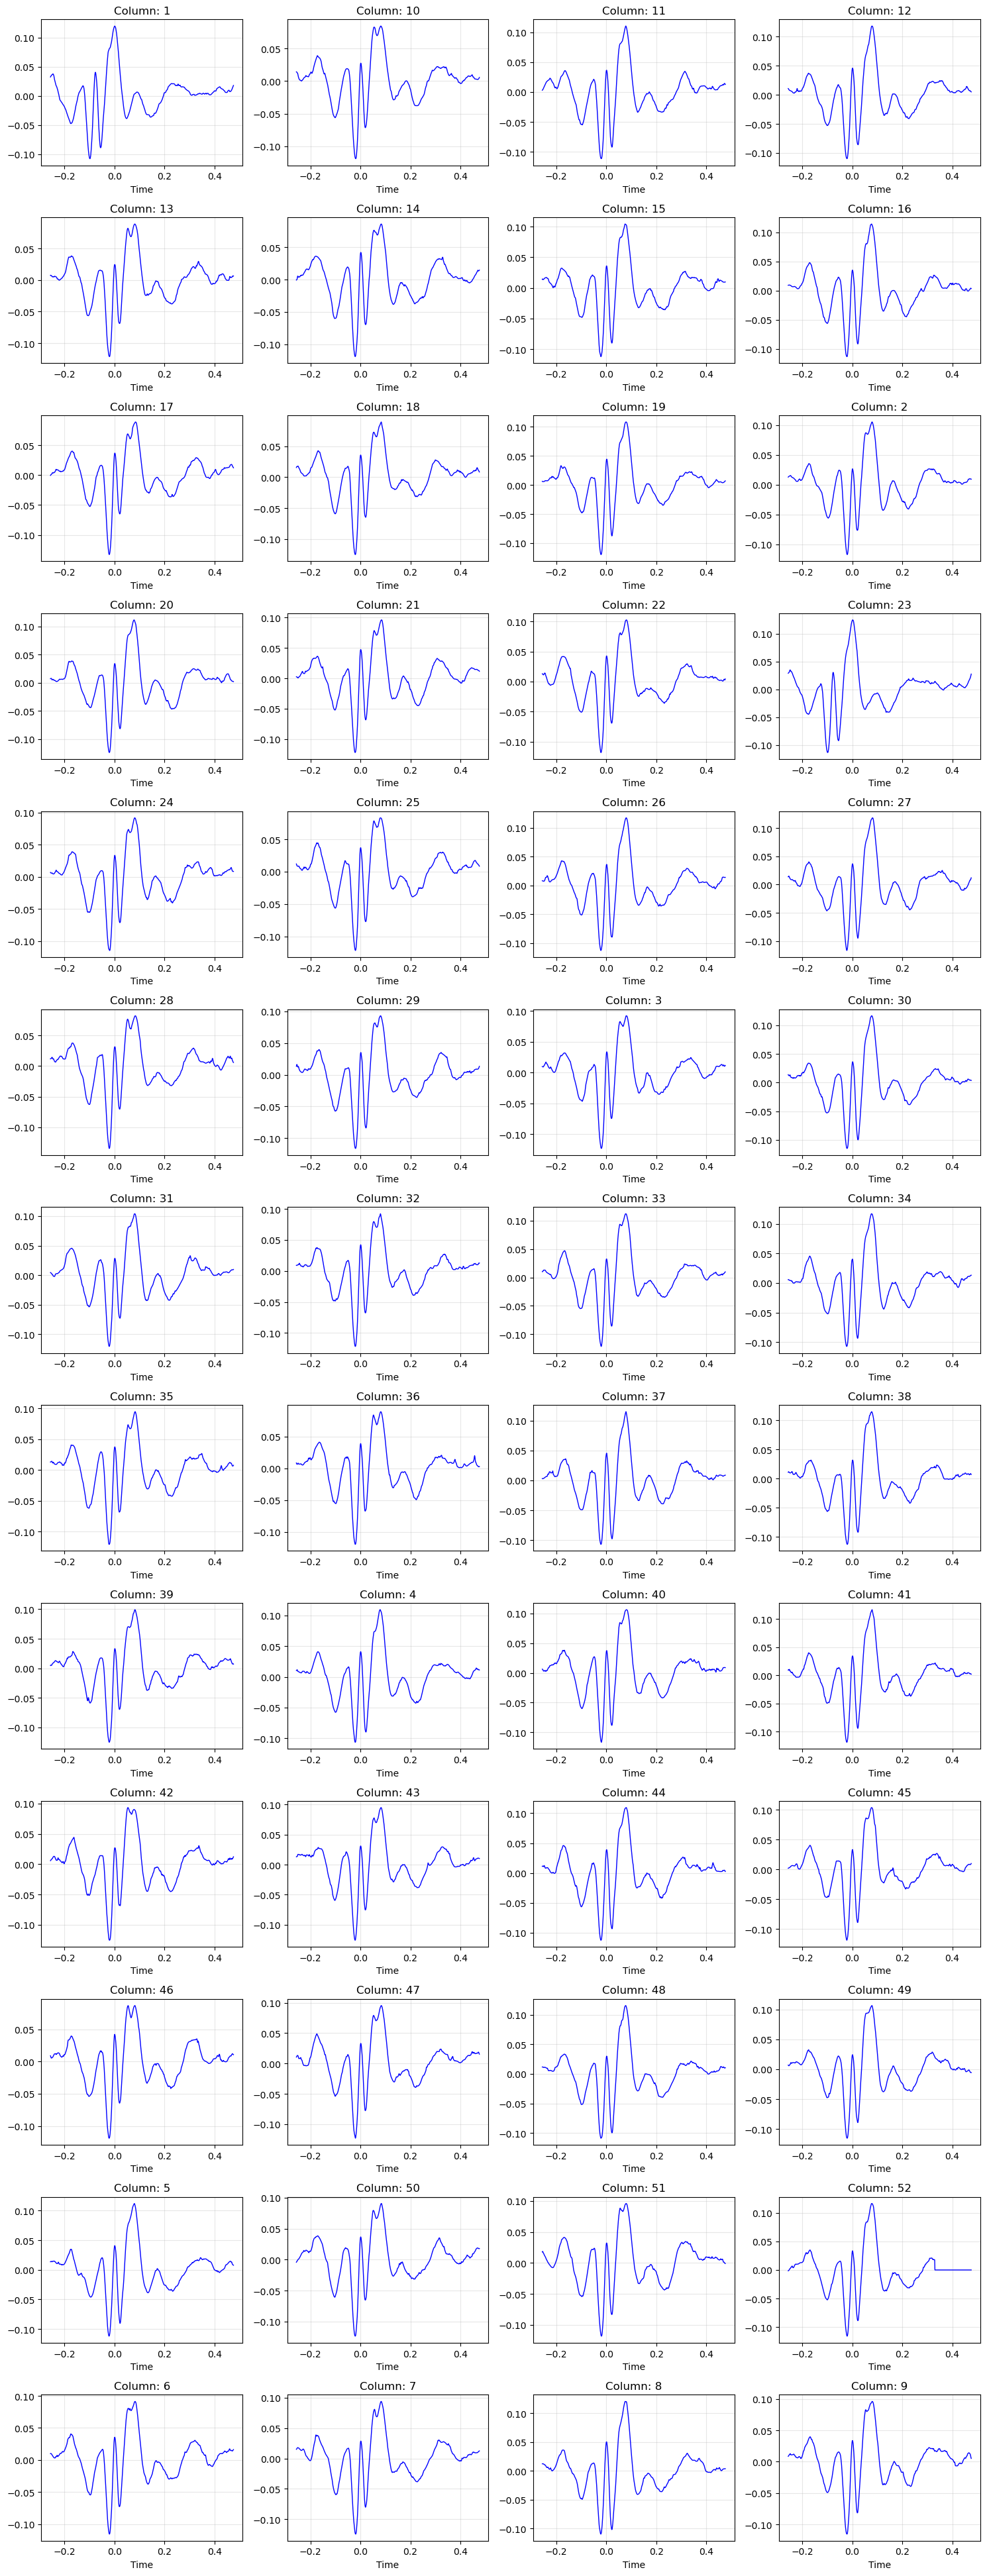

In [39]:
n_cols = min(4, df_pivoted.shape[1])  # 每行最多4列
n_rows = int(np.ceil(df_pivoted.shape[1] / n_cols))

# 创建子图网格
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.flatten()  # 将二维轴数组转换为一维

# 遍历所有列并绘制到各自的子图
for i, col in enumerate(df_pivoted.columns):
    ax = axes[i]
    df_pivoted[col].plot(ax=ax, color="blue", linewidth=1)
    ax.set_title(f"Column: {col}")
    ax.grid(True, alpha=0.3)

# 隐藏多余的子图（如果有）
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

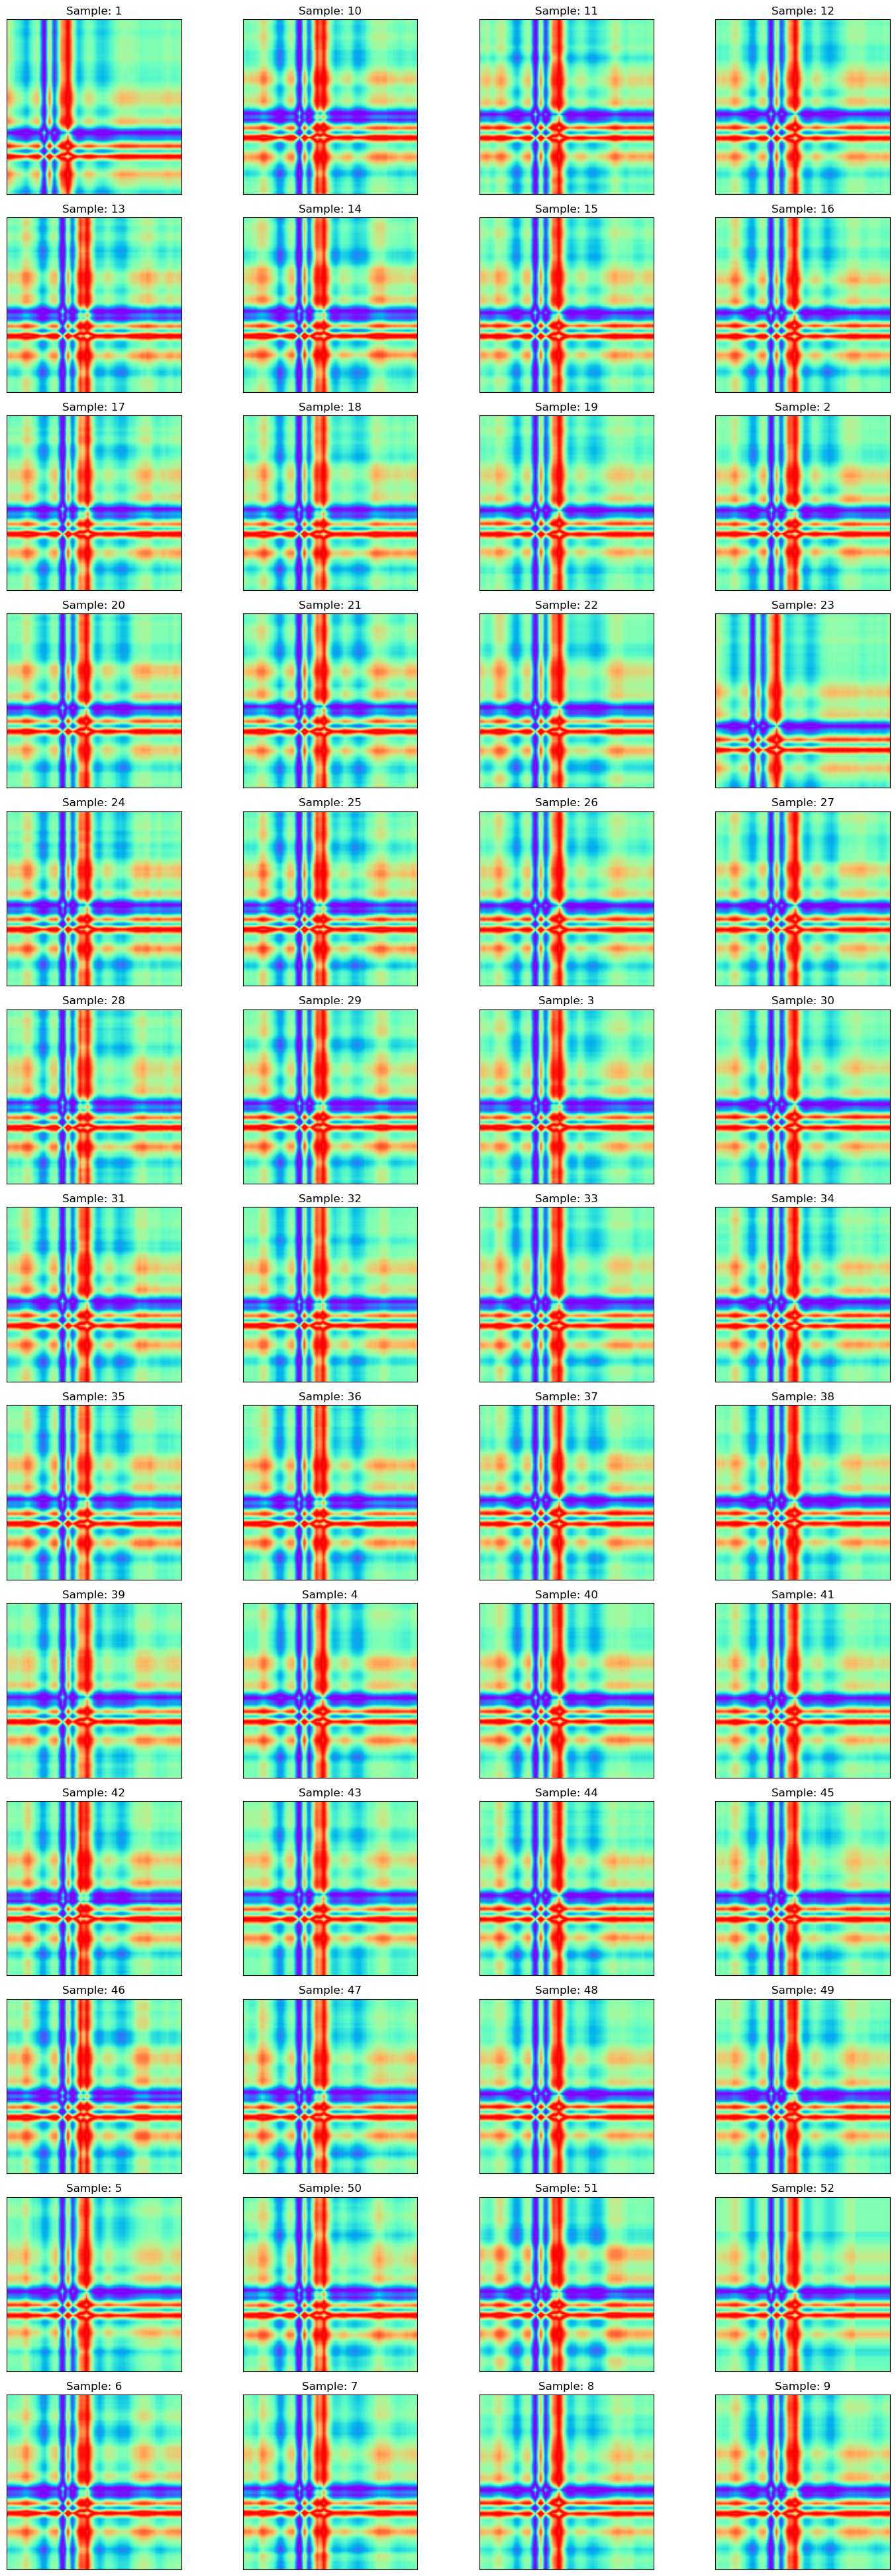

In [46]:
n_cols = len(df_pivoted.columns)
n_rows = (n_cols + 3) // 4  # 每行最多4张图，计算所需行数
fig, axes = plt.subplots(n_rows, min(n_cols, 4),  # 限制每行最多4列
                         figsize=(15, 3*n_rows),
                         squeeze=False)           # 确保axes始终是二维数组

axes_flat = axes.flatten()

# 遍历所有列并绘制到各自的子图
for i, col in enumerate(df_pivoted.columns):
    ax = axes_flat[i]
    sig = df_pivoted[col].to_numpy()
    sig = paa(sig)
    sig = sig.reshape(1, -1)
    gadf = GramianAngularField(method='difference')
    X_gadf = gadf.fit_transform(sig)

    im = ax.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    # fig.colorbar(im, ax=ax)  # 添加颜色条
    
    ax.set_title(f"Sample: {col}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)  # 图像通常不需要网格线

for j in range(i+1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

In [26]:
def write_image(sig_T, save_path):
    sig = sig_T.reshape(1, -1)
    gadf = GramianAngularField(method='difference')
    X_gadf = gadf.fit_transform(sig)
    plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    plt.xticks([])
    plt.yticks([])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close('all')

In [28]:
def sig2img(rec_path, save_root, person_name, sg_num, is_train):

    csv_file = '/sample_rec_1.csv' if is_train else '/sample_rec_2.csv'
    df_pivoted = pd.read_csv(str(rec_path.absolute()) + csv_file)
    col_lst = df_pivoted.columns.to_list()
    col_lst.remove('Time')
    # 选择一个样本集合
    def iter_st(sample_lst, st_name):
        for idx, col in enumerate(sample_lst):
            if idx >= sg_num:
                break
            sig_T = df_pivoted[col].to_numpy()
            for i, sig_t in enumerate(paa(sig_T, [0.5, 0.4])):
                save_path = save_root.joinpath(f'{st_name}/{person_name}/img_{col}_{i + 1}.png')
                write_image(sig_t, save_path)
                
    if is_train:
        train_lst = random.sample(col_lst, int(sg_num * 0.8))   
        for del_ele in train_lst:
            col_lst.remove(del_ele)
        val_lst = random.sample(col_lst, int(sg_num * 0.2))
        iter_st(train_lst, 'train')
        iter_st(val_lst, 'val')
    else:
        test_lst = random.sample(col_lst, sg_num)
        iter_st(test_lst, 'test')
        


In [29]:
train_val_num = 10
test_num = 5

save_root = Path('ecg_id_img')

In [30]:
for person_sg in segment_path.iterdir():

    if person_sg.is_dir():
        person_name = person_sg.name
        # 生成训练集和验证集
        sig2img(person_sg, save_root, person_name, train_val_num, True)
        print('write', person_name)
        # 生成测试集
        # sig2img(person_sg, test_save_path.joinpath(person_name), test_num, False)

write Person_01
write Person_02
write Person_03
write Person_04
write Person_05
write Person_06
write Person_07
write Person_08
write Person_09
write Person_10
write Person_11
write Person_12
write Person_13
write Person_14
write Person_15
write Person_16
write Person_17
write Person_18
write Person_19
write Person_20
write Person_21
write Person_22
write Person_23
write Person_24
write Person_25
write Person_26
write Person_27
write Person_28
write Person_29
write Person_30
write Person_31
write Person_32
write Person_33
write Person_34
write Person_35
write Person_36
write Person_37
write Person_38
write Person_39
write Person_40
write Person_41
write Person_42
write Person_43
write Person_44
write Person_45
write Person_46
write Person_47
write Person_48
write Person_49
write Person_50
write Person_51
write Person_52
write Person_53
write Person_54
write Person_55
write Person_56
write Person_57
write Person_58
write Person_59
write Person_60
write Person_61
write Person_62
write Pe